In [5]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from tqdm import tqdm
import progressbar
from alive_progress import alive_bar
import time

In [9]:
trainers = np.array(pd.read_csv("emnist-balanced-train.csv", nrows=500000, header=None))
m, n = trainers.shape
np.random.shuffle(trainers)
trainers = trainers.T
testers = np.array(pd.read_csv("emnist-balanced-test.csv", nrows=18000, header=None))
p, q = testers.shape
np.random.shuffle(testers)
testers = testers.T

In [10]:
labels = trainers[0]
images = trainers[1:n]/255
testLabels = testers[0]
testImages = testers[1:q]/255


In [11]:
labelDictionary = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: 'A',
    11: 'B',
    12: 'C',
    13: 'D',
    14: 'E',
    15: 'F',
    16: 'G',
    17: 'H',
    18: 'I',
    19: 'J',
    20: 'K',
    21: 'L',
    22: 'M',
    23: 'N',
    24: 'O',
    25: 'P',
    26: 'Q',
    27: 'R',
    28: 'S',
    29: 'T',
    30: 'U',
    31: 'V',
    32: 'W',
    33: 'X',
    34: 'Y',
    35: 'Z',
    36: 'a',
    37: 'b',
    38: 'c',
    39: 'd',
    40: 'e',
    41: 'f',
    42: 'g',
    43: 'h',
    44: 'i',
    45: 'j',
    46: 'k',
    47: 'l',
    48: 'm',
    49: 'n',
    50: 'o',
    51: 'p',
    52: 'q',
    53: 'r',
    54: 's',
    55: 't',
    56: 'u',
    57: 'v',
    58: 'w',
    59: 'x',
    60: 'y',
    61: 'z',   
}

In [12]:
files = ["hidden1bias.npy", "outputbias.npy", "hidden1weights.npy", "outputweights.npy"]
def initalizeFiles():
    arrays = []
    
    hidden1bias = np.random.rand(62, 1)-0.5
    arrays.append(hidden1bias)
    
    outputbias = np.random.rand(62, 1)-0.5
    arrays.append(outputbias)
    
    
    hidden1weights = np.random.rand(62, 784)-0.5
    arrays.append(hidden1weights)

    
    outputweights = np.random.rand(62, 62)-0.5
    arrays.append(outputweights)
    
    for count, file in enumerate(files):
        np.save(file, arrays[count])


In [13]:
def Softmax(x):
    return np.exp(x) / sum(np.exp(x))

def SoftmaxPrime(x):
    return Softmax(x)*(1 - Softmax(x))

def Sigmoid(x):
    return 1/(1 + np.exp(-x))

def SigmoidPrime(x):
    return Sigmoid(x)*(1 - Sigmoid(x))   

def ReLU(x):
    return np.maximum(0, x)

def ReLUPrime(x):
    return np.where(x > 0, 1, 0)

In [14]:
def forwardProp(w1, w2, b1, b2, input):
    z1 = np.dot(w1, input) + b1
    a1 = ReLU(z1)
    z2 = np.dot(w2, a1) + b2
    a2 = Softmax(z2)
    return z1, a1, z2, a2

In [15]:
def oneHot(label):
    oneHotY = np.zeros((label.size, 62))
    oneHotY[np.arange(label.size), label] = 1
    oneHotY = oneHotY.T
    return oneHotY

In [16]:
def backProp(z1, a1, z2, a2, yhat, input, hidden1weights, outputweights):
    onehotyhat = oneHot(yhat)
    
    outputDelta = 2*(a2 - onehotyhat)
    hidden1Delta  = np.dot(outputweights.T, outputDelta) * ReLUPrime(z1)
    
    dw1 = 1/m*np.dot(hidden1Delta, input.T)
    dw2 = 1/m*np.dot(outputDelta, a1.T)

    
    db1 = (1/m*np.sum(hidden1Delta, axis=1)).reshape((62, 1))
    db2 = (1/m*np.sum(outputDelta, axis=1)).reshape((62, 1))
    
    return dw1, dw2, db1, db2

def update_params(w1, w2, b1, b2, dw1, dw2,  db1, db2,  alpha):
    w1 = w1 - alpha * dw1
    w2 = w2 - alpha * dw2
    
    b1 = b1 - alpha * db1
    b2 = b2 - alpha * db2
    
    np.save("hidden1weights.npy", w1)
    np.save("outputweights.npy", w2)

    np.save("hidden1bias.npy", b1)
    np.save("outputbias.npy", b2)

    
    return w1, w2, b1, b2

In [32]:
def predictions(a2):
    return np.argmax(a2, 0)

def accuracy(predictions, yhat):
    return np.sum(predictions == yhat) / yhat.size

def cost(a2, yhat):
    onehotyhat = oneHot(yhat)
    return 1/m*np.sum(np.sum((np.square(a2 - onehotyhat)),axis=0))

In [18]:
def gradient_descent(input, labels, alpha, iterations):
    w1 = np.load("hidden1weights.npy")
    w2 = np.load("outputweights.npy")
    b1 = np.load("hidden1bias.npy")
    b2 = np.load("outputbias.npy")
    for i in range(iterations):
        z1, a1, z2, a2 = forwardProp(w1, w2, b1, b2, input)
        dw1, dw2, db1, db2 = backProp(z1, a1, z2, a2, labels, input, w1, w2)
        w1, w2, b1, b2 = update_params(w1, w2, b1, b2, dw1, dw2, db1, db2, alpha)
        if i % 10 == 0:
            print("Iteration:", i)
            predics = predictions(a2)
            print("Accuracy:", accuracy(predics, labels))
            print("Cost:", cost(a2, labels))
    return w1, w2, b1, b2

In [19]:
def imageVisualiser(input):
    input = input.reshape(28, 28)
    input = np.fliplr(input)
    input = np.rot90(input)
    return input

In [20]:
def visualTest():
    w1 = np.load("hidden1weights.npy")
    w2 = np.load("outputweights.npy")
    b1 = np.load("hidden1bias.npy")
    b2 = np.load("outputbias.npy")
    imgNum = random.randint(0, p-1)
    label = testLabels[imgNum]
    image = testImages[:, imgNum, None]
    z1, a1, z2, a2 = forwardProp(w1, w2, b1, b2, image)
    prediction = labelDictionary[int(predictions(a2))]
    actual = labelDictionary[label]
    print(f"Predicted Character: {prediction} \nActual Character: {actual}")
    plt.imshow(imageVisualiser(image), cmap='gray')


In [21]:
def testAccuracy(iterations):
    accuracy = 0
    w1 = np.load("hidden1weights.npy")
    w2 = np.load("outputweights.npy")
    b1 = np.load("hidden1bias.npy")
    b2 = np.load("outputbias.npy")
    for i in range(iterations):
        imgNum = random.randint(0, p-1)
        label = testLabels[imgNum]
        image = testImages[:, imgNum, None]
        z1, a1, z2, a2 = forwardProp(w1, w2, b1, b2, image)
        prediction = int(predictions(a2))
        if label == prediction:
            accuracy += 1
    return accuracy/iterations

In [36]:
def testCostCalc(a2, yhat):
    onehotyhat = oneHot(yhat)
    return 1/p*np.sum(np.sum((np.square(a2 - onehotyhat)),axis=0))

In [37]:
def testCost(input, labels):
    w1 = np.load("hidden1weights.npy")
    w2 = np.load("outputweights.npy")
    b1 = np.load("hidden1bias.npy")
    b2 = np.load("outputbias.npy")
    z1, a1, z2, a2 = forwardProp(w1, w2, b1, b2, input)
    print("Cost:", testCostCalc(a2, labels))

In [38]:
testCost(testImages, testLabels)

Cost: 0.2667666747864142


In [26]:
w1, w2, b1, b2 = gradient_descent(images, labels, 0.1, 1)

Iteration: 0
Accuracy: 0.8478280141843971
Cost: 0.21567834901944918


In [31]:
testAccuracy(10000)

0.8151

Predicted Character: 3 
Actual Character: 3


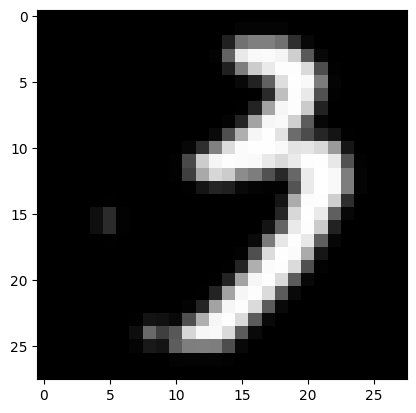

In [48]:
visualTest()